Version 1.1.0

# Mean encodings

In this programming assignment you will be working with `1C` dataset from the final competition. You are asked to encode `item_id` in 4 different ways:

    1) Via KFold scheme;  
    2) Via Leave-one-out scheme;
    3) Via smoothing scheme;
    4) Via expanding mean scheme.

**You will need to submit** the correlation coefficient between resulting encoding and target variable up to 4 decimal places.

### General tips

* Fill NANs in the encoding with `0.3343`.
* Some encoding schemes depend on sorting order, so in order to avoid confusion, please use the following code snippet to construct the data frame. This snippet also implements mean encoding without regularization.

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from grader import Grader

%matplotlib inline

# Read data

In [2]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Aggregate data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.

In [4]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [5]:
all_data.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


# Mean encodings without regularization

After we did the techinical work, we are ready to actually *mean encode* the desired `item_id` variable. 

Here are two ways to implement mean encoding features *without* any regularization. You can use this code as a starting point to implement regularized techniques. 

#### Method 1

In [6]:
# Calculate a mapping: {item_id: target_mean}
item_id_target_mean = all_data.groupby('item_id').target.mean()

# In our non-regularized case we just *map* the computed means to the `item_id`'s
all_data['item_target_enc'] = all_data['item_id'].map(item_id_target_mean)

# Fill NaNs
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

# Print correlation
encoded_feature = all_data['item_target_enc'].values
print(np.corrcoef(all_data['target'].values, encoded_feature)[0][1])

0.483038698862


#### Method 2

In [7]:
'''
     Differently to `.target.mean()` function `transform` 
   will return a dataframe with an index like in `all_data`.
   Basically this single line of code is equivalent to the first two lines from of Method 1.
'''
all_data['item_target_enc'] = all_data.groupby('item_id')['target'].transform('mean')

# Fill NaNs
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

# Print correlation
encoded_feature = all_data['item_target_enc'].values
print(np.corrcoef(all_data['target'].values, encoded_feature)[0][1])

0.483038698862


See the printed value? It is the correlation coefficient between the target variable and your new encoded feature. You need to **compute correlation coefficient** between the encodings, that you will implement and **submit those to coursera**.

In [8]:
grader = Grader()

# 1. KFold scheme

Explained starting at 41 sec of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

**Now it's your turn to write the code!** 

You may use 'Regularization' video as a reference for all further tasks.

First, implement KFold scheme with five folds. Use KFold(5) from sklearn.model_selection. 

1. Split your data in 5 folds with `sklearn.model_selection.KFold` with `shuffle=False` argument.
2. Iterate through folds: use all but the current fold to calculate mean target for each level `item_id`, and  fill the current fold.

    *  See the **Method 1** from the example implementation. In particular learn what `map` and pd.Series.map functions do. They are pretty handy in many situations.

In [9]:
print(all_data['item_id'].unique())
print('num of unique values: {}'.format(len(all_data['item_id'].unique())))
print('num of samples: {:,}'.format(all_data.shape[0]))

[   19    27    28 ..., 22005 22006 22158]
num of unique values: 21807
num of samples: 10,913,850


In [10]:
type(all_data.groupby('item_id')['target'].mean())

pandas.core.series.Series

### Plot mean values upon `item_id`

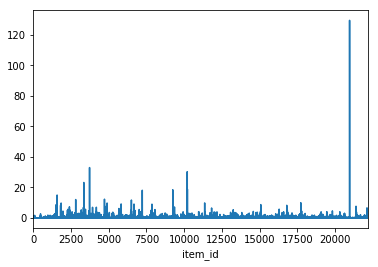

In [11]:
all_data.groupby('item_id')['target'].mean().plot()

In [12]:
# YOUR CODE GOES HERE
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=False)

for index_train, index_valid in kf.split(all_data):
    X_tr, X_val = all_data.iloc[index_train], all_data.iloc[index_valid]
    
    # target coding of valid dataset depends on train dataset
    X_tr_group = X_tr.groupby('item_id')['target'] 
    X_val['item_target_enc'] = X_val['item_id'].map(X_tr_group.mean())
    
    # copy target encoding back to all_data
    all_data.iloc[index_valid] = X_val
    

all_data['item_target_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['item_target_enc'].values
    

# You will need to compute correlation like that
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
grader.submit_tag('KFold_scheme', corr)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


0.41645907128
Current answer for task KFold_scheme is: 0.41645907128


# 2. Leave-one-out scheme

Now, implement leave-one-out scheme. Note that if you just simply set the number of folds to the number of samples and run the code from the **KFold scheme**, you will probably wait for a very long time. 

To implement a faster version, note, that to calculate mean target value using all the objects but one *given object*, you can:

1. Calculate sum of the target values using all the objects.
2. Then subtract the target of the *given object* and divide the resulting value by `n_objects - 1`. 

Note that you do not need to perform `1.` for every object. And `2.` can be implemented without any `for` loop.

It is the most convenient to use `.transform` function as in **Method 2**.

In [13]:
%%time
# YOUR CODE GOES HERE

# Calculate sum of the target values using all the objects.
target_sum = all_data.groupby('item_id')['target'].transform('sum')

# Then subtract the target of the given object and divide the resulting value by n_objects - 1.
n_objects = all_data.groupby('item_id')['target'].transform('count')

all_data['item_target_enc'] = (target_sum - all_data['target']) / (n_objects - 1)
all_data['item_target_enc'].fillna(0.3343, inplace=True)
encoded_feature = all_data['item_target_enc'].values


corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
grader.submit_tag('Leave-one-out_scheme', corr)
print()

0.480384831129
Current answer for task Leave-one-out_scheme is: 0.480384831129

CPU times: user 1.3 s, sys: 905 ms, total: 2.2 s
Wall time: 4.41 s


# 3. Smoothing

Explained starting at 4:03 of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

Next, implement smoothing scheme with $\alpha = 100$. Use the formula from the first slide in the video and $0.3343$ as `globalmean`. Note that `nrows` is the number of objects that belong to a certain category (not the number of rows in the dataset).

In [14]:
%%time

# YOUR CODE GOES HERE
alpha = 100

item_id_target_mean = all_data.groupby('item_id')['target'].transform('mean')
n_objects = all_data.groupby('item_id')['target'].transform('count')

all_data['item_target_enc'] = (item_id_target_mean * n_objects + 0.3343*alpha) / (n_objects + alpha)

all_data['item_target_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['item_target_enc'].values


corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
grader.submit_tag('Smoothing_scheme', corr)
print()

0.48181987971
Current answer for task Smoothing_scheme is: 0.48181987971

CPU times: user 1.36 s, sys: 869 ms, total: 2.23 s
Wall time: 4.5 s


# 4. Expanding mean scheme

Explained starting at 5:50 of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

Finally, implement the *expanding mean* scheme. It is basically already implemented for you in the video, but you can challenge yourself and try to implement it yourself. You will need [`cumsum`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.cumsum.html) and [`cumcount`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.GroupBy.cumcount.html) functions from pandas.

In [15]:
print('shape of cumulative sum: {:,}'.format(all_data.groupby('item_id')['target'].cumsum().shape[0]))

shape of cumulative sum: 10,913,850


In [16]:
# YOUR CODE GOES HERE
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id').cumcount()

all_data['item_target_enc'] = cumsum / cumcnt
all_data['item_target_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['item_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
grader.submit_tag('Expanding_mean_scheme', corr)

0.502524521108
Current answer for task Expanding_mean_scheme is: 0.502524521108


## Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. Note: Token expires 30 minutes after generation.

In [17]:
STUDENT_EMAIL = 'brandon.hy.lin.0@gmail.com' # EMAIL HERE
STUDENT_TOKEN = 'EC3Bgq6dNzp8q92S'  # TOKEN HERE
grader.status()

You want to submit these numbers:
Task KFold_scheme: 0.41645907128
Task Leave-one-out_scheme: 0.480384831129
Task Smoothing_scheme: 0.48181987971
Task Expanding_mean_scheme: 0.502524521108


In [18]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
